In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")


In [3]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [4]:
train[train['price'] > 0].reset_index(drop = True)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.0,NaN,2367927.861
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693
13998,9256,Delta,Flat,NaN,6.0,1.0,3348918.718


In [5]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [7]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [8]:
#Find the mean and fill the missing values with forward fill to adjust the skewness of the data 
std_bedroom = train['bedroom'].std()
std_bathroom = train['bathroom'].std()



train['parking_space'].fillna(0, inplace = True) 
train['bedroom'].fillna(std_bedroom, inplace=True)
train['bathroom'].fillna(std_bathroom, inplace=True)

In [9]:
#Fill in the missing value with forward fill to adjust the skewness of the data 
col = ['loc', 'title']
for col in train:
    train[col].fillna(method = 'ffill', inplace= True)

In [10]:
sub.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [11]:
train.title.unique()

array(['Semi-detached duplex', 'Apartment', 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

In [12]:
data = train.drop("price", axis=1).append(test)

In [13]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space
0,3583,Katsina,6,2.000000,2.0,1.0
1,2748,Ondo,9,2.441165,2.0,4.0
2,9261,Ekiti,9,7.000000,5.0,0.0
3,2224,Anambra,5,5.000000,2.0,4.0
4,10300,Kogi,4,2.441165,5.0,6.0


In [14]:
# Calculate the frequency of each category in the 'loc' column
category_frequencies = data['loc'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()

# Map the 'loc' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space
0,3583,0.02880,6,2.000000,2.0,1.0
1,2748,0.02795,9,2.441165,2.0,4.0
2,9261,0.02745,9,7.000000,5.0,0.0
3,2224,0.03020,5,5.000000,2.0,4.0
4,10300,0.02755,4,2.441165,5.0,6.0


In [15]:
train.shape[0]

14000

In [16]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

In [17]:
X.shape, y.shape, test_df.shape

((14000, 6), (14000,), (6000, 6))

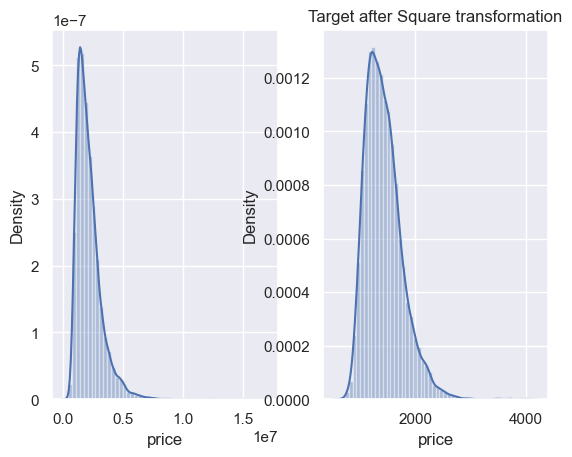

In [18]:
sns.set()
y_transformed = pd.Series(np.sqrt(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Square transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print(f'mse = {mean_squared_error(y_test, lgb_preds, squared=False)}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 6
[LightGBM] [Info] Start training from score 2135673.350592
mse = 669683.4516383938


In [21]:
predictions = lgb.predict(test_df)
predictions

array([2253038.86884961, 1103736.32575103, 1422621.91053294, ...,
       1952557.57832157, 1611595.45124777, 3154426.64352977])

In [22]:
sub['price'] = predictions
sub.head()

,ID,price
0,845,2.253039e+06
1,1924,1.103736e+06
2,10718,1.422622e+06
3,12076,6.330722e+06
4,12254,1.989863e+06


In [23]:
sub.to_csv('modellll.csv', index=False)

In [24]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 500,
    'colsample_bytree': 0.86,
 'learning_rate': 0.032,
 'max_depth': 7,
 'subsample': 0.85}


fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], )#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.285301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 14.473420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

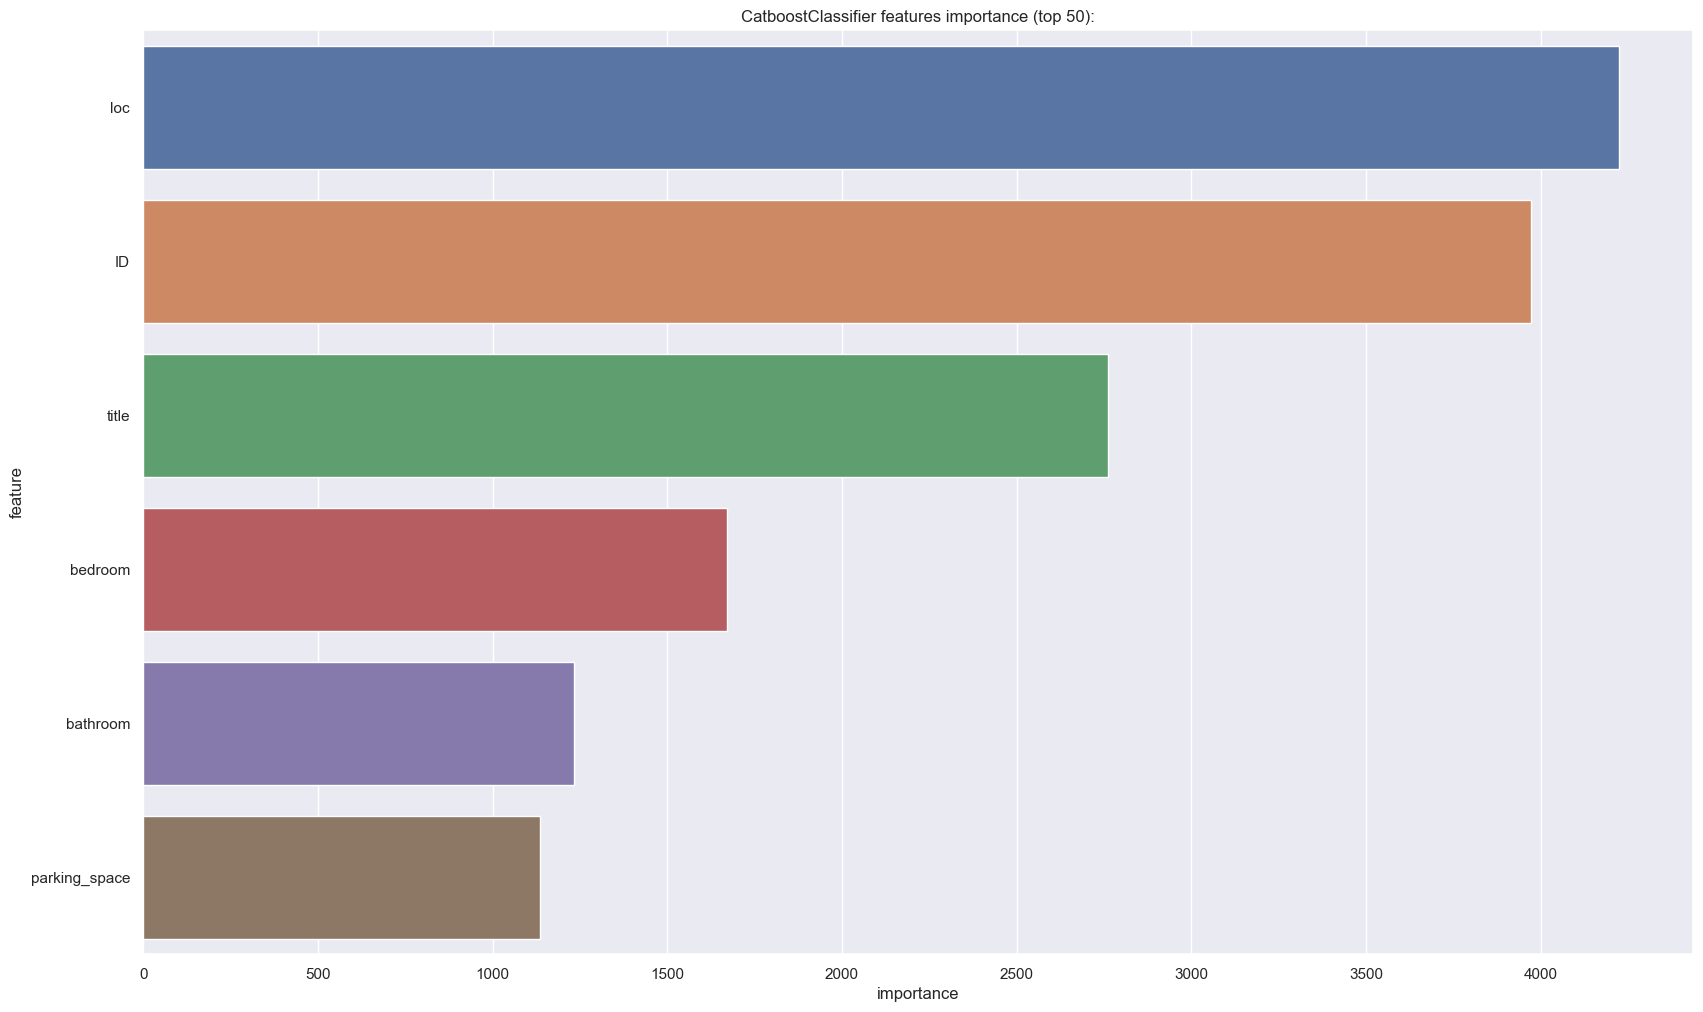

In [25]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

In [26]:
sub.head()

,ID,price
0,845,2.253039e+06
1,1924,1.103736e+06
2,10718,1.422622e+06
3,12076,6.330722e+06
4,12254,1.989863e+06


In [27]:
sub['price'] =  np.mean(fold_pred, axis = 0)

In [28]:
sub.head()

,ID,price
0,845,2.210915e+06
1,1924,1.138838e+06
2,10718,1.319251e+06
3,12076,7.344772e+06
4,12254,1.979886e+06


In [29]:
sub.to_csv('submissions.csv', index=False)